In [1]:
#modules
import mysql.connector
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt 

In [2]:
#Functions
#get columns names from table
def get_colnames(my_cursor, column_name):
    col_names = []
    try:
        query = "SELECT COLUMN_NAME\
                FROM INFORMATION_SCHEMA.COLUMNS\
                WHERE TABLE_SCHEMA = DATABASE() AND TABLE_NAME = \'{}\'".format(column_name) #selecting column names from provided table
        my_cursor.execute(query)
        my_result = my_cursor.fetchall()
        for result in my_result:
            col_names.append(result[0])
        return col_names
    except:
        print("Error")
        
#Reading data and saving to dataframe
def read_data(my_cursor, query, columns):
    my_cursor.execute(query)
    my_result = my_cursor.fetchall()
    pd_data = []

    for result in my_result:
        result = list(result)
        pd_data.append(result)
    return pd.DataFrame(pd_data, columns=columns)

def display_data(df, columns):
    print(tabulate(df, columns, tablefmt = 'psql', showindex = False))

In [3]:
#connecting with database
database = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "pw123")

In [4]:
#Initializing cursor
my_cursor = database.cursor()

In [5]:
#Choose database
my_cursor.execute("USE gravity_books")

In [6]:
####DATA ANALYSIS

In [7]:
#Top publishers
query = "SELECT publisher_name, COUNT(*) AS nb_of_books FROM publisher\
        JOIN book ON book.publisher_id = publisher.publisher_id\
        GROUP BY book.publisher_id\
        ORDER BY nb_of_books DESC\
        LIMIT 10"
columns = ['Publisher_name', 'Number of books']

In [8]:
top_publishers = read_data(my_cursor, query, columns)

In [9]:
print("TOP 10 publishing houses")
display_data(top_publishers, columns)

TOP 10 publishing houses
+------------------+-------------------+
| Publisher_name   |   Number of books |
|------------------+-------------------|
| Vintage          |               318 |
| Penguin Books    |               261 |
| Penguin Classics |               184 |
| Mariner Books    |               150 |
| Ballantine Books |               145 |
| HarperCollins    |               113 |
| Harper Perennial |               112 |
| Pocket Books     |               111 |
| Bantam           |               110 |
| VIZ Media LLC    |                88 |
+------------------+-------------------+


In [10]:
#Top authors
query = "SELECT author.author_name, COUNT(*) AS nb_of_books FROM book_author\
        JOIN book ON book.book_id = book_author.book_id\
        JOIN author ON author.author_id = book_author.author_id\
        GROUP BY book_author.author_id\
        ORDER BY nb_of_books DESC LIMIT 10"
columns = ['Author', 'Number of books']

In [11]:
top_authors = read_data(my_cursor, query, columns)

In [12]:
display_data(top_authors, columns)

+------------------+-------------------+
| Author           |   Number of books |
|------------------+-------------------|
| Stephen King     |                70 |
| Sandra Brown     |                46 |
| P.G. Wodehouse   |                45 |
| Mercedes Lackey  |                43 |
| Orson Scott Card |                40 |
| J.R.R. Tolkien   |                39 |
| Rumiko Takahashi |                39 |
| James Patterson  |                39 |
| Agatha Christie  |                39 |
| Margaret Weis    |                36 |
+------------------+-------------------+


In [13]:
#Authors generating the most revenue
query = "SELECT author.author_name, COUNT(*) AS nb_of_books , SUM(order_line.price) as sum_price\
        FROM book_author\
        JOIN book ON book.book_id = book_author.book_id\
        JOIN author ON author.author_id = book_author.author_id\
        JOIN order_line ON order_line.book_id = book.book_id\
        GROUP BY book_author.author_id\
        ORDER BY sum_price DESC\
        LIMIT 10"
columns = ['Author', 'Number of sold books', 'Income']

In [14]:
most_revenue = read_data(my_cursor, query, columns)

In [15]:
display_data(most_revenue, columns)

+---------------------+------------------------+----------+
| Author              |   Number of sold books |   Income |
|---------------------+------------------------+----------|
| Stephen King        |                    100 |  1004.1  |
| Sandra Brown        |                     63 |   732.09 |
| P.G. Wodehouse      |                     81 |   703.51 |
| Mercedes Lackey     |                     72 |   675.61 |
| James Patterson     |                     55 |   630.44 |
| Orson Scott Card    |                     61 |   605.67 |
| Roald Dahl          |                     61 |   590.16 |
| Terry Pratchett     |                     52 |   584.15 |
| Rumiko Takahashi    |                     56 |   538.71 |
| William Shakespeare |                     52 |   506.74 |
+---------------------+------------------------+----------+


In [16]:
#Authors haven't sold any book
query = "SELECT author_name\
        FROM book_author\
        JOIN book ON book.book_id = book_author.book_id\
        JOIN author ON author.author_id = book_author.author_id\
        LEFT JOIN order_line ON order_line.book_id = book.book_id\
        GROUP BY author_name\
        HAVING SUM(IFNULL(price, 0)) = 0\
        ORDER BY author_name"
columns = ['Author']

In [17]:
any_sold = read_data(my_cursor, query, columns)

In [18]:
display_data(any_sold, columns)

+----------------------------------+
| Author                           |
|----------------------------------|
| A.E. van Vogt                    |
| A.J. Jacobs                      |
| A.T. Hatto                       |
| Aaron Shepard                    |
| Abigail Adams                    |
| Abraham Moore                    |
| Adam Ginsberg                    |
| Adam Long                        |
| Adam Rex                         |
| Adèle Lang                       |
| Adi Granov                       |
| Adrian Alphona                   |
| Adrián Ferrero                   |
| Adrian Geoffrey Gilbert          |
| Adrian Guelke                    |
| Adrian Reynolds                  |
| Aimee Bender                     |
| Akhil Sharma                     |
| Akira Yoshida                    |
| Al Dempster                      |
| Al Gore                          |
| Alain Defossé                    |
| Alak Zenkar                      |
| Alan Aldridge                    |
|

In [22]:
#Languages of books in stock
languages = "(\'English\', \'United States English\', \'Spanish\', \'British English\', \'French\', \'German\', \'Japanese\', \'Multiple Languages\')"

query = "SELECT\
        CASE\
            WHEN book_language.language_name IN {} THEN book_language.language_name\
            ELSE \'other\' END AS \'language\',\
        COUNT(*) FROM book_language\
        JOIN book ON book.language_id = book_language.language_id\
        GROUP BY language\
        ORDER BY COUNT(*) DESC".format(languages)
columns = ['Language', 'Number of books']

In [23]:
languages_nb = read_data(my_cursor, query, columns)

In [24]:
display_data(languages_nb, columns)

+-----------------------+-------------------+
| Language              |   Number of books |
|-----------------------+-------------------|
| English               |              8911 |
| United States English |              1409 |
| Spanish               |               218 |
| British English       |               214 |
| French                |               144 |
| German                |                99 |
| other                 |                67 |
| Japanese              |                46 |
| Multiple Languages    |                19 |
+-----------------------+-------------------+


In [25]:
#Delivery overwiew
query = "SELECT method_name, COUNT(*) AS nb , SUM(cost) AS tot_cost\
        FROM shipping_method\
        JOIN cust_order ON cust_order.shipping_method_id = shipping_method.method_id\
        GROUP BY method_name\
        ORDER BY nb DESC"
columns = ['shipping method', 'number of deliveries', 'total cost']

In [26]:
deliveries = read_data(my_cursor, query, columns)

In [27]:
display_data(deliveries, columns)

+-------------------+------------------------+--------------+
| shipping method   |   number of deliveries |   total cost |
|-------------------+------------------------+--------------|
| Express           |                   1918 |      22824.2 |
| Standard          |                   1906 |      11245.4 |
| International     |                   1877 |      45986.5 |
| Priority          |                   1849 |      16456.1 |
+-------------------+------------------------+--------------+


In [14]:
#Shipment time
query = "SELECT country.country_name,\
        shipping_method.method_name,\
        TIMESTAMPDIFF(hour, min(status_date), max(status_date)) AS 'time',\
        ROUND(AVG(TIMESTAMPDIFF(hour, min(status_date), max(status_date))) OVER (PARTITION BY method_name), 2) AS avg_time\
        FROM order_history\
        JOIN cust_order ON cust_order.order_id = order_history.order_id\
        JOIN shipping_method ON shipping_method.method_id = cust_order.shipping_method_id\
        JOIN address ON address.address_id = cust_order.dest_address_id\
        JOIN country ON country.country_id = address.country_id\
        GROUP BY order_history.order_id\
        HAVING order_id IN (SELECT order_id FROM order_history\
        WHERE status_id = 5)\
        ORDER BY method_name, country.country_name, time"
columns = ['Destination', 'Shipping method', 'Delivery time (hours)', 'AVG delivery time for method (hours)'] 

In [15]:
delivery_time = read_data(my_cursor, query, columns)

In [16]:
display_data(delivery_time, columns)

+--------------------------+-------------------+-------------------------+----------------------------------------+
| Destination              | Shipping method   |   Delivery time (hours) |   AVG delivery time for method (hours) |
|--------------------------+-------------------+-------------------------+----------------------------------------|
| Albania                  | Express           |                       9 |                                  10.44 |
| Azerbaijan               | Express           |                      14 |                                  10.44 |
| Bhutan                   | Express           |                      14 |                                  10.44 |
| Brazil                   | Express           |                       3 |                                  10.44 |
| Brazil                   | Express           |                      16 |                                  10.44 |
| Burkina Faso             | Express           |                      22

In [23]:
#Delivery destination
query = "SELECT\
        CASE\
            WHEN country.country_name IN\
            (SELECT * FROM (SELECT country.country_name FROM cust_order\
            JOIN address ON address.address_id = cust_order.dest_address_id\
            JOIN country ON country.country_id = address.country_id\
            GROUP BY address.country_id\
            ORDER BY COUNT(*) DESC\
            LIMIT 15)\
            AS test)\
            THEN country.country_name\
            ELSE 'other'\
        END AS 'country',\
        COUNT(*) as nb_of_deliveries\
        FROM cust_order\
        JOIN address ON address.address_id = cust_order.dest_address_id\
        JOIN country ON country.country_id = address.country_id\
        GROUP BY country\
        ORDER BY COUNT(*) DESC"
columns = ['Country', 'Number of deliveries']

In [24]:
delivery_destination = read_data(my_cursor, query, columns)

In [25]:
display_data(delivery_destination, columns)

+--------------------------+------------------------+
| Country                  |   Number of deliveries |
|--------------------------+------------------------|
| other                    |                   2097 |
| China                    |                   1314 |
| Indonesia                |                   1041 |
| Russia                   |                    449 |
| Philippines              |                    363 |
| Poland                   |                    307 |
| France                   |                    306 |
| Portugal                 |                    291 |
| Brazil                   |                    275 |
| United States of America |                    225 |
| Peru                     |                    213 |
| Sweden                   |                    170 |
| Czech Republic           |                    136 |
| Canada                   |                    133 |
| Colombia                 |                    123 |
| Serbia                   |

In [6]:
#Status of delivery
query = "SELECT order_status.status_value, COUNT(*)\
        FROM order_history\
        JOIN order_status ON order_history.status_id = order_status.status_id\
        GROUP BY order_status.status_value"
columns = ['Status', 'Number of orders']

In [7]:
delivery_status = read_data(my_cursor, query, columns)

In [8]:
display_data(delivery_status, columns)

+----------------------+--------------------+
| Status               |   Number of orders |
|----------------------+--------------------|
| Order Received       |               7549 |
| Pending Delivery     |               6800 |
| Delivery In Progress |               4000 |
| Delivered            |               3500 |
| Cancelled            |                300 |
| Returned             |                200 |
+----------------------+--------------------+


In [22]:
#Number of Transactions Over Time
query = "SELECT\
        EXTRACT(YEAR FROM order_date) AS year,\
        EXTRACT(MONTH FROM order_date) AS month,\
        COUNT(*) AS nb_of_transactions\
        FROM cust_order\
        GROUP BY year, month\
        ORDER BY year, month"
columns = ['Year', 'Month', 'Transactions']

In [23]:
transactions = read_data(my_cursor, query, columns)

In [27]:
#display_data(transactions, columns)

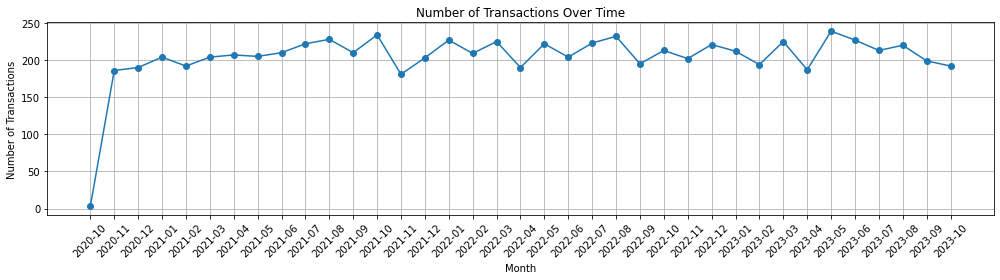

In [29]:
trans_for_plt = pd.DataFrame(transactions)

# Combine 'Year' and 'Month' columns into a single 'Date' column and format it as 'YYYY-MM'
trans_for_plt['Date'] = pd.to_datetime(trans_for_plt[['Year', 'Month']].assign(day=1)).dt.strftime('%Y-%m')

# Plot the number of transactions
plt.figure(figsize=(14, 4))
plt.plot(trans_for_plt['Date'], trans_for_plt['Transactions'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()